In [1]:
import os
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client
client = Client()

In [3]:
nc_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_raw/'
nc_files = sorted(glob.glob(nc_path+'*.nc'))   # sort to order by date in filename
nc_Sv_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_Sv/'
nc_Sv_files = sorted(glob.glob(nc_Sv_path+'*_Sv.nc'))   # sort to order by date in filename

In [4]:
nc_files[0]

'/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_raw/OOI-D20150817-T000000.nc'

In [5]:
ds = xr.open_mfdataset(nc_files[0], group='Beam', combine='by_coords').\
                                chunk({'ping_time':4000})
ds

<xarray.Dataset>
Dimensions:                         (frequency: 3, ping_time: 28718, range_bin: 1046)
Coordinates:
  * frequency                       (frequency) float32 120000.0 ... 200000.0
  * ping_time                       (ping_time) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-17T23:19:59.703000
  * range_bin                       (range_bin) int64 0 1 2 3 ... 1043 1044 1045
Data variables:
    beamwidth_receive_alongship     (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    beamwidth_receive_athwartship   (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    beamwidth_transmit_alongship    (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    beamwidth_transmit_athwartship  (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    beam_direction_x                (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    beam_direction_y                (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    beam_direction_z                (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    angle_offset_alongship          (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    angle_offset_athwartship        (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    angle_sensitivity_alongship     (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    angle_sensitivity_athwartship   (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    equivalent_beam_angle           (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    gain_correction                 (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    non_quantitative_processing     (frequency) int32 dask.array<chunksize=(3,), meta=np.ndarray>
    sample_interval                 (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    sample_time_offset              (frequency) int32 dask.array<chunksize=(3,), meta=np.ndarray>
    transmit_bandwidth              (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    transmit_duration_nominal       (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    transmit_power                  (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    transducer_offset_x             (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    transducer_offset_y             (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    transducer_offset_z             (frequency) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    backscatter_r                   (frequency, ping_time, range_bin) float64 dask.array<chunksize=(3, 4000, 1046), meta=np.ndarray>
    angles                          (frequency, ping_time, range_bin) float64 dask.array<chunksize=(3, 4000, 1046), meta=np.ndarray>
    pieces                          int64 ...
    channel_id                      (frequency) object dask.array<chunksize=(3,), meta=np.ndarray>
    gpt_software_version            (frequency) object dask.array<chunksize=(3,), meta=np.ndarray>
    sa_correction                   (frequency) float64 dask.array<chunksize=(3,), meta=np.ndarray>

In [6]:
ds_sv = xr.open_mfdataset(nc_Sv_files[0], combine='by_coords').\
                                chunk({'ping_time':4000})
ds_sv

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 28718, range_bin: 1046)
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * ping_time  (ping_time) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-17T23:19:59.703000
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045
Data variables:
    Sv         (frequency, ping_time, range_bin) float64 dask.array<chunksize=(3, 4000, 1046), meta=np.ndarray>
    range      (frequency, range_bin) float64 dask.array<chunksize=(3, 1046), meta=np.ndarray>

## Get binning parameters along `ping_time` and `range_bin`

In [7]:
noise_est_range_bin_size = 5
noise_est_ping_size = 1200

Get sample thickness needed for calculating recorded sonar range.

In [8]:
with xr.open_dataset(nc_files[0], group="Beam") as ds_beam:
    with xr.open_dataset(nc_files[0], group="Environment") as ds_env:
        sample_thickness = ds_env.sound_speed_indicative * ds_beam.sample_interval / 2  # sample thickness
sample_thickness

<xarray.DataArray (frequency: 3)>
array([0.19121777, 0.19121777, 0.19121777], dtype=float32)
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0

In [9]:
# Adjust noise_est_range_bin_size because range_bin_size may be an inconvenient value
r_data_sz = ds_sv['range_bin'].size   # dimension of range_bin in data file
num_r_per_tile = (np.round(noise_est_range_bin_size / sample_thickness).
                  astype(int)).values.max()  # num of range_bin per tile
noise_est_range_bin_size = (num_r_per_tile * sample_thickness).values

num_tile_range_bin = np.ceil(r_data_sz / num_r_per_tile).astype(int)

print(f'There are {num_r_per_tile} range bins in each noise_est tile.')
print(f'There are a total of {num_tile_range_bin} range_bin bins for each raw data tile.')

There are 26 range bins in each noise_est tile.
There are a total of 41 range_bin bins for each raw data tile.


In [10]:
r_tile_bin_edge = np.arange(num_tile_range_bin+1) * num_r_per_tile - 1
r_tile_bin_edge

array([  -1,   25,   51,   77,  103,  129,  155,  181,  207,  233,  259,
        285,  311,  337,  363,  389,  415,  441,  467,  493,  519,  545,
        571,  597,  623,  649,  675,  701,  727,  753,  779,  805,  831,
        857,  883,  909,  935,  961,  987, 1013, 1039, 1065])

In [11]:
# Produce a new coordinate for groupby operation
p_data_sz = ds_sv['ping_time'].size   # dimension of ping_time in data file
if np.mod(p_data_sz, noise_est_ping_size) == 0:
    num_tile_ping = np.ceil(p_data_sz / noise_est_ping_size).astype(int) + 1
    p_idx = np.array([np.arange(num_tile_ping - 1)] * noise_est_ping_size).squeeze().T.ravel()
else:
    num_tile_ping = np.ceil(p_data_sz / noise_est_ping_size).astype(int)
    pad = np.ones(p_data_sz - (num_tile_ping - 1) * noise_est_ping_size, dtype=int) \
          * (num_tile_ping - 1)
    p_idx = np.hstack(
        (np.array([np.arange(num_tile_ping - 1)] * noise_est_ping_size).squeeze().T.ravel(), pad))

In [12]:
p_idx

array([ 0,  0,  0, ..., 23, 23, 23])

In [13]:
p_data_sz/noise_est_ping_size

23.93166666666667

In [14]:
p_tile_bin_edge = np.arange(num_tile_ping+1) * noise_est_ping_size - 1
p_tile_bin_edge

array([   -1,  1199,  2399,  3599,  4799,  5999,  7199,  8399,  9599,
       10799, 11999, 13199, 14399, 15599, 16799, 17999, 19199, 20399,
       21599, 22799, 23999, 25199, 26399, 27599, 28799])

In [15]:
tvg_correction_factor = 2
with xr.open_dataset(nc_files[0], group="Beam") as ds_beam:
    range_meter = ds_beam.range_bin * sample_thickness - \
                  tvg_correction_factor * sample_thickness  # DataArray [frequency x range_bin]
    range_meter = range_meter.where(range_meter > 0, other=0)

In [16]:
range_meter

<xarray.DataArray (range_bin: 1046, frequency: 3)>
array([[  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       ...,
       [199.05769359, 199.05769359, 199.05769359],
       [199.24891135, 199.24891135, 199.24891135],
       [199.44012912, 199.44012912, 199.44012912]])
Coordinates:
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045
  * frequency  (frequency) float32 120000.0 38000.0 200000.0

In [17]:
ds_sv['range']

<xarray.DataArray 'range' (frequency: 3, range_bin: 1046)>
dask.array<open_dataset-492e4ddb3f794769b9513d2936132204range, shape=(3, 1046), dtype=float64, chunksize=(3, 1046), chunktype=numpy.ndarray>
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045

In [18]:
np.array_equal(range_meter.sel(frequency=38000).values, ds_sv['range'].sel(frequency=38000).values)

True

## Calculate TVG and ABS for transmission loss compensation

In [19]:
with xr.open_dataset(nc_files[0], group="Environment") as ds_env:
    seawater_absorption = ds_env.absorption_indicative
seawater_absorption

<xarray.DataArray 'absorption_indicative' (frequency: 3)>
array([0.03744 , 0.009785, 0.052688], dtype=float32)
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
Attributes:
    long_name:  Indicative acoustic absorption
    units:      dB/m
    valid_min:  0.0

In [20]:
TVG = np.real(20 * np.log10(range_meter.where(range_meter >= 1, other=1)))
ABS = 2 * seawater_absorption * range_meter

## Load Sv

In [21]:
Sv = ds_sv['Sv']
Sv.coords['ping_idx'] = ('ping_time', np.arange(Sv['ping_time'].size))
Sv = Sv.swap_dims({'ping_time': 'ping_idx'})
Sv

<xarray.DataArray 'Sv' (frequency: 3, ping_idx: 28718, range_bin: 1046)>
dask.array<rechunk-merge, shape=(3, 28718, 1046), dtype=float64, chunksize=(3, 4000, 1046), chunktype=numpy.ndarray>
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
    ping_time  (ping_idx) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-17T23:19:59.703000
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045
  * ping_idx   (ping_idx) int64 0 1 2 3 4 5 ... 28713 28714 28715 28716 28717

## Noise removal based on ping number

In [22]:
def remove_n(x):
    p_c_lin = 10 ** ((x - ABS - TVG) / 10)
    nn = 10 * np.log10(p_c_lin.groupby_bins('range_bin',r_tile_bin_edge).\
                       mean().min(dim='range_bin_bins')) + ABS + TVG
    return x.where(x > nn, other=np.nan)

In [23]:
Sv

<xarray.DataArray 'Sv' (frequency: 3, ping_idx: 28718, range_bin: 1046)>
dask.array<rechunk-merge, shape=(3, 28718, 1046), dtype=float64, chunksize=(3, 4000, 1046), chunktype=numpy.ndarray>
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
    ping_time  (ping_idx) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-17T23:19:59.703000
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045
  * ping_idx   (ping_idx) int64 0 1 2 3 4 5 ... 28713 28714 28715 28716 28717

In [24]:
Sv_clean = Sv.groupby_bins('ping_idx',p_tile_bin_edge).map(remove_n)

In [25]:
Sv_clean

<xarray.DataArray 'Sv' (frequency: 3, ping_idx: 28718, range_bin: 1046)>
dask.array<getitem, shape=(3, 28718, 1046), dtype=float64, chunksize=(3, 1200, 1046), chunktype=numpy.ndarray>
Coordinates:
  * frequency      (frequency) float32 120000.0 38000.0 200000.0
  * range_bin      (range_bin) int64 0 1 2 3 4 5 ... 1041 1042 1043 1044 1045
    ping_time      (ping_idx) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-17T23:19:59.703000
  * ping_idx       (ping_idx) int64 0 1 2 3 4 ... 28713 28714 28715 28716 28717
    ping_idx_bins  (ping_idx) object (-1, 1199] (-1, 1199] ... (27599, 28799]

Sanity check for removing bad values:

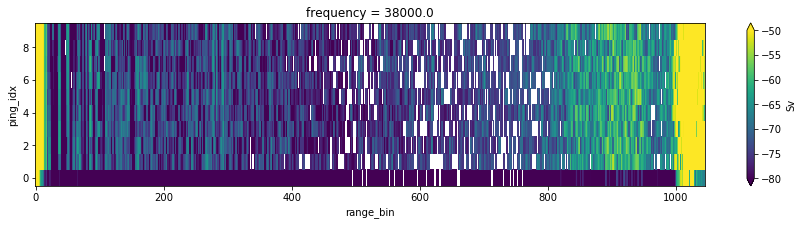

In [26]:
fig, ax = plt.subplots(figsize=(15,3))
Sv_clean.sel(frequency=38000).isel(ping_idx=slice(0,10)).plot(ax=ax,y='ping_idx',vmin=-80,vmax=-50)

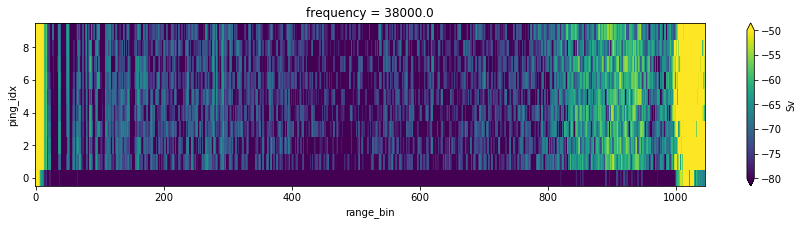

In [27]:
fig, ax = plt.subplots(figsize=(15,3))
Sv.sel(frequency=38000).isel(ping_idx=slice(0,10)).plot(ax=ax,y='ping_idx',vmin=-80,vmax=-50)

Sanity check:

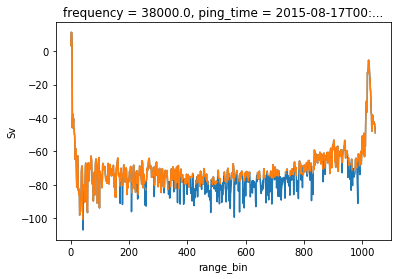

In [29]:
Sv.sel(frequency=38000,ping_idx=1).plot()
Sv_clean.sel(frequency=38000,ping_idx=1).plot()

## Noise removal based on `ping_time`

In [30]:
def remove_n(x):
    p_c_lin = 10 ** ((x - ABS - TVG) / 10)
    nn = 10 * np.log10(p_c_lin.groupby_bins('range_bin',r_tile_bin_edge).\
                       mean().min(dim='range_bin_bins')) + ABS + TVG
    return x.where(x > nn, other=np.nan)

In [31]:
Sv = Sv.swap_dims({'ping_idx': 'ping_time'})
Sv

<xarray.DataArray 'Sv' (frequency: 3, ping_time: 28718, range_bin: 1046)>
dask.array<rechunk-merge, shape=(3, 28718, 1046), dtype=float64, chunksize=(3, 4000, 1046), chunktype=numpy.ndarray>
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * ping_time  (ping_time) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-17T23:19:59.703000
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045
    ping_idx   (ping_time) int64 0 1 2 3 4 5 ... 28713 28714 28715 28716 28717

In [32]:
Sv_clean_time = Sv.groupby('ping_time.hour').map(remove_n)
Sv_clean_time

<xarray.DataArray 'Sv' (frequency: 3, ping_time: 28718, range_bin: 1046)>
dask.array<getitem, shape=(3, 28718, 1046), dtype=float64, chunksize=(3, 1197, 1046), chunktype=numpy.ndarray>
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045
  * ping_time  (ping_time) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-17T23:19:59.703000
    ping_idx   (ping_time) int64 0 1 2 3 4 5 ... 28713 28714 28715 28716 28717
    hour       (ping_time) int64 0 0 0 0 0 0 0 0 0 ... 23 23 23 23 23 23 23 23

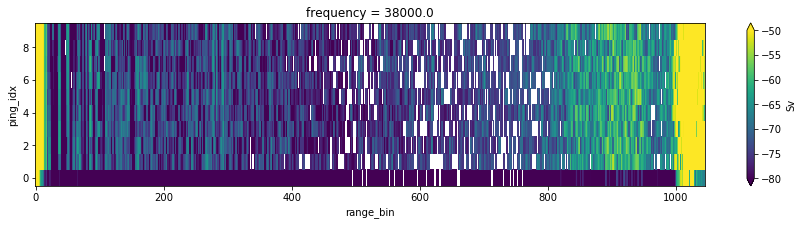

In [33]:
fig, ax = plt.subplots(figsize=(15,3))
Sv_clean_time.sel(frequency=38000).isel(ping_time=slice(0,10)).plot(ax=ax,y='ping_idx',vmin=-80,vmax=-50)

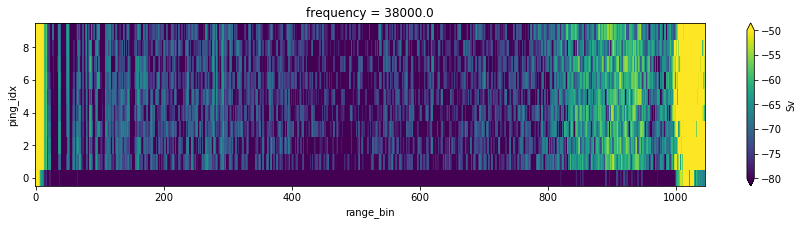

In [34]:
fig, ax = plt.subplots(figsize=(15,3))
Sv.sel(frequency=38000).isel(ping_time=slice(0,10)).plot(ax=ax,y='ping_idx',vmin=-80,vmax=-50)

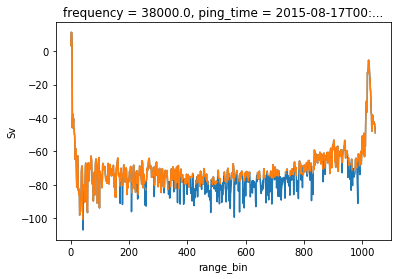

In [35]:
Sv.sel(frequency=38000).isel(ping_time=1).plot()
Sv_clean_time.sel(frequency=38000).isel(ping_time=1).plot()

## Not sure what went wrong in the below

In [36]:
power_linear_TL = 10 ** ((ds_sv['Sv']-ABS-TVG)/10)  # remove TL and convert to linear domain
power_linear_TL

<xarray.DataArray (frequency: 3, ping_time: 28718, range_bin: 1046)>
dask.array<pow, shape=(3, 28718, 1046), dtype=float64, chunksize=(3, 4000, 1046), chunktype=numpy.ndarray>
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * ping_time  (ping_time) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-17T23:19:59.703000
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045

In [37]:
power_linear_TL_coarsen = power_linear_TL.coarsen(
    ping_time=noise_est_ping_size, range_bin=num_r_per_tile, boundary='pad',squeeze=False).mean()
power_linear_TL_coarsen_min = power_linear_TL_coarsen.min(dim='range_bin')
power_log_coarsen_min = 10 * np.log10(power_linear_TL_coarsen_min) + ABS + TVG

In [38]:
power_linear_TL_coarsen

<xarray.DataArray (frequency: 3, ping_time: 24, range_bin: 41)>
dask.array<mean_agg-aggregate, shape=(3, 24, 41), dtype=float64, chunksize=(3, 4, 40), chunktype=numpy.ndarray>
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * ping_time  (ping_time) datetime64[ns] 2015-08-17T00:10:10.478174166 ... 2015-08-17T23:10:39.497937388
  * range_bin  (range_bin) float64 12.5 38.5 64.5 ... 1e+03 1.026e+03 1.042e+03

TypeError: unsupported operand type(s) for *: 'int' and 'QuadMesh'

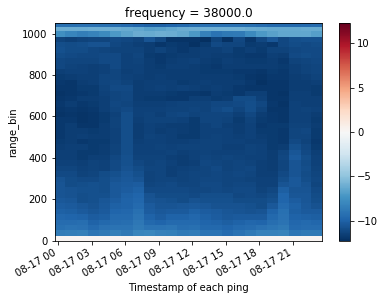

In [39]:
10*np.log10(power_linear_TL_coarsen.sel(frequency=38000)).plot(x='ping_time')

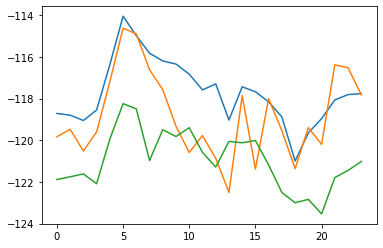

In [40]:
plt.plot(10*np.log10(power_linear_TL_coarsen_min.T))
plt.show()

In [41]:
power_log_coarsen_min

<xarray.DataArray (frequency: 3, ping_time: 24, range_bin: 1046)>
dask.array<add, shape=(3, 24, 1046), dtype=float64, chunksize=(3, 4, 1046), chunktype=numpy.ndarray>
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * ping_time  (ping_time) datetime64[ns] 2015-08-17T00:10:10.478174166 ... 2015-08-17T23:10:39.497937388
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045

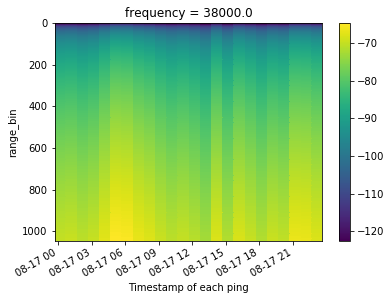

In [42]:
power_log_coarsen_min.sel(frequency=38000).plot(x='ping_time',yincrease=False)

Add an additional coordinate `ping_idx` for binning according to ping number, and rename `ping_idx` to `ping_idx_bins` so the group names corresponds with results from groupby_bins.

In [43]:
power_log_coarsen_min.coords['ping_idx'] = ('ping_time', np.arange(power_log_coarsen_min['ping_time'].size))
power_log_coarsen_min = power_log_coarsen_min.rename({'ping_idx': 'ping_idx_bins'})
power_log_coarsen_min = power_log_coarsen_min.swap_dims({'ping_time': 'ping_idx_bins'})
power_log_coarsen_min

<xarray.DataArray (frequency: 3, ping_idx_bins: 24, range_bin: 1046)>
dask.array<add, shape=(3, 24, 1046), dtype=float64, chunksize=(3, 4, 1046), chunktype=numpy.ndarray>
Coordinates:
  * frequency      (frequency) float32 120000.0 38000.0 200000.0
    ping_time      (ping_idx_bins) datetime64[ns] 2015-08-17T00:10:10.478174166 ... 2015-08-17T23:10:39.497937388
  * range_bin      (range_bin) int64 0 1 2 3 4 5 ... 1041 1042 1043 1044 1045
  * ping_idx_bins  (ping_idx_bins) int64 0 1 2 3 4 5 6 ... 17 18 19 20 21 22 23

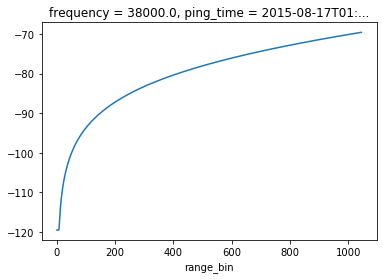

In [44]:
power_log_coarsen_min.sel(frequency=38000).isel(ping_idx_bins=1).plot()

In [45]:
Sv.groupby_bins('ping_idx',p_tile_bin_edge)

DataArrayGroupBy, grouped over 'ping_idx_bins' 
24 groups with labels (-1,, 1199], ..., (27599,, 28799].

In [46]:
Sv.groupby_bins('ping_idx',p_tile_bin_edge,labels=np.arange(24)).mean()

<xarray.DataArray 'Sv' (frequency: 3, ping_idx_bins: 24, range_bin: 1046)>
dask.array<transpose, shape=(3, 24, 1046), dtype=float64, chunksize=(3, 1, 1046), chunktype=numpy.ndarray>
Coordinates:
  * ping_idx_bins  (ping_idx_bins) int64 0 1 2 3 4 5 6 ... 17 18 19 20 21 22 23
  * frequency      (frequency) float32 120000.0 38000.0 200000.0
  * range_bin      (range_bin) int64 0 1 2 3 4 5 ... 1041 1042 1043 1044 1045

In [47]:
Sv.groupby_bins('ping_idx',p_tile_bin_edge,labels=np.arange(24)) - power_log_coarsen_min

<xarray.DataArray (frequency: 3, ping_time: 28718, range_bin: 1046)>
dask.array<getitem, shape=(3, 28718, 1046), dtype=float64, chunksize=(3, 1200, 1046), chunktype=numpy.ndarray>
Coordinates:
  * frequency      (frequency) float32 120000.0 38000.0 200000.0
  * range_bin      (range_bin) int64 0 1 2 3 4 5 ... 1041 1042 1043 1044 1045
  * ping_time      (ping_time) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-17T23:19:59.703000
    ping_idx       (ping_time) int64 0 1 2 3 4 ... 28713 28714 28715 28716 28717
    ping_idx_bins  (ping_time) int64 0 0 0 0 0 0 0 0 ... 23 23 23 23 23 23 23 23

In [48]:
aa = (Sv.groupby_bins('ping_idx',p_tile_bin_edge,labels=np.arange(24)) - power_log_coarsen_min).values

In [49]:
power_log_coarsen_min

<xarray.DataArray (frequency: 3, ping_idx_bins: 24, range_bin: 1046)>
dask.array<add, shape=(3, 24, 1046), dtype=float64, chunksize=(3, 4, 1046), chunktype=numpy.ndarray>
Coordinates:
  * frequency      (frequency) float32 120000.0 38000.0 200000.0
    ping_time      (ping_idx_bins) datetime64[ns] 2015-08-17T00:10:10.478174166 ... 2015-08-17T23:10:39.497937388
  * range_bin      (range_bin) int64 0 1 2 3 4 5 ... 1041 1042 1043 1044 1045
  * ping_idx_bins  (ping_idx_bins) int64 0 1 2 3 4 5 6 ... 17 18 19 20 21 22 23

In [50]:
Sv_wo_noise = Sv.groupby_bins('ping_idx',p_tile_bin_edge) - power_log_coarsen_min
Sv_wo_noise

<xarray.DataArray (frequency: 3, ping_time: 28718, range_bin: 1046)>
dask.array<getitem, shape=(3, 28718, 1046), dtype=float64, chunksize=(3, 1200, 1046), chunktype=numpy.ndarray>
Coordinates:
  * frequency      (frequency) float32 120000.0 38000.0 200000.0
  * range_bin      (range_bin) int64 0 1 2 3 4 5 ... 1041 1042 1043 1044 1045
  * ping_time      (ping_time) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-17T23:19:59.703000
    ping_idx       (ping_time) int64 0 1 2 3 4 ... 28713 28714 28715 28716 28717
    ping_idx_bins  (ping_time) object (-1, 1199] (-1, 1199] ... (27599, 28799]

In [51]:
Sv_wo_noise_values = Sv_wo_noise.values

In [52]:
Sv_wo_noise_values[0,0,:50]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])